In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import gym
import gym_env
import glob

In [10]:
ss = [[1,2], [3,4]]
for i, (s, a) in enumerate(ss):
    print(i, s, a)

0 1 2
1 3 4


In [34]:
def actionSelect(Map, s, actions):
    if len(Map) == 0:
        return actions[0]
    for a in actions:
        if a not in Map[s].keys():
            return a
    q = float('-inf')
    for a in actions:
        if Map[s][a][1] > q:
            action = a
            q = Map[s][a][1]
    return action

def maxQ(Map, s, actions):
    for a in actions:
        if a not in Map[s].keys():
            return 0
    q = float('-inf')
    for a in actions:
        if Map[s][a][1] > q:
            q = Map[s][a][1]
    return q

def updateMap(Map, sm, expirence, actions, gamma):
    s, a, s1, r = expirence
    if s1 in np.array(sm)[:,0]:
        Map[s][a] = [s1, float('-inf')]
    elif s1 in Map.keys():
        Map[s][a] = [s1, r+gamma*maxQ(Map, s1, actions)]
    else:
        Map[s][a] = [s1, r]
        Map[s1] = {}
    return Map

def updateSM(sm, work):
    s, a = work
    SM = []
    for ss, aa in sm:
        if ss == s:
            SM.append([s,a])
            return SM
        else:
            SM.append([ss, aa])
    SM.append([s, a])
    return SM

def foundGoal(Map, sm, s1, r, gamma):
    if r < 0:
        s, a = sm[-1]
        Map[s][a] = [s1, float('-inf')]
        return Map
    n = len(sm)
    for i, (s, a) in enumerate(sm):
        if i<n-1:
            Map[s][a] = [sm[i+1][0], np.power(gamma, n-i)*r]
        else:
            Map[s][a] = [s1, r]
    return Map


def mazeSolve(env, gamma, noEpisodes, singleGoal):
    Map = {}
    states = []
    for e in range(noEpisodes):
        sm = []
        s = env.reset()
        done = env.done
        if s not in Map.keys():
            Map[s] = {}
        states.append(s)
        while not done:
            actions = env.action_available()
            try:
                a = actionSelect(Map, s, actions)
            except:
                break
            sm = updateSM(sm, (s, a))
            s1, r, done = env.step(a)
            states.append(s1)
            actions = env.action_available()
            Map = updateMap(Map, sm, (s, a, s1, r), actions, gamma)
            if done and singleGoal:
                Map = foundGoal(Map, sm, s1, r, gamma)
            s = s1
    return states, sm, Map

In [54]:
data = np.array([
    [1,0,1,1,1,1,1,1,1,1,1],
    [1,0,1,0,0,1,1,0,0,0,0],
    [1,1,1,0,1,1,1,1,1,1,1],
    [1,0,0,0,1,0,1,0,1,0,1],
    [1,1,0,1,1,0,1,0,1,0,1],
    [1,1,0,1,1,0,1,1,0,0,0],
    [1,0,0,1,1,0,1,1,1,1,1],
    [1,1,0,1,1,0,0,1,1,0,0],
    [1,1,0,0,1,1,0,1,1,1,1],
    [0,1,0,1,1,1,1,0,1,0,1],
    [1,1,1,1,0,0,1,0,1,0,3]
])

params = { 'maze':data, 'start':0 }
env = gym.make('maze-world-env02-v0', **params)
states, sm, MAP = mazeSolve(env, 0.9, 30, False)
videoMaker(data, states)

In [46]:
def showMaze(data, s): 
    rows, cols = data.shape
    r = s // cols
    c = s % cols
    data[r, c] = 2
    offset = 4
    cell = 10
    length = cols*cell + 2*offset
    width = rows*cell + 2*offset
    design = np.array([128,128,128]*offset*length, dtype='uint8').reshape((offset, length, 3))
    Cell = np.array([128,128,128]*cell*cell, dtype='uint8').reshape((cell, cell, 3))
    for i in range(rows):
        row = np.array([128,128,128]*cell*offset, dtype='uint8').reshape((cell, offset, 3))
        for j in range(cols):
            if data[i, j] == 0:
                row = np.hstack((row, Cell))
            elif data[i, j] == 1:
                row = np.hstack((row, np.full((cell, cell, 3), 255, dtype='uint8')))
            elif data[i, j] == 2:
                start = np.array([0,0,255]*cell*cell, dtype='uint8').reshape((cell, cell, 3))
                row = np.hstack((row, start))
            elif data[i, j] == 3:
                end = np.array([0,255,0]*cell*cell, dtype='uint8').reshape((cell, cell, 3))
                row = np.hstack((row, end))
            elif data[i, j] == 4:
                hole = np.array([255,0,0]*cell*cell, dtype='uint8').reshape((cell, cell, 3))
                row = np.hstack((row, hole))
        row = np.hstack((row, np.array([128,128,128]*cell*offset, dtype='uint8').reshape((cell, offset, 3))))
        design = np.vstack((design, row))
    design = np.vstack((design, np.array([128,128,128]*offset*length, dtype='uint8').reshape((offset, length, 3))))
    return design

def videoMaker(data, states):
    images = []
    for s in states:
        maze = data.copy()
        images.append(showMaze(maze, s))
    
    for i in range(len(images)):
        cv.imwrite(f'images/{i}.png', images[i])
    
    img_array = []
    for i in range(len(images)):
        filename = f'images/{i}.png'
        img = cv.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
    
    out = cv.VideoWriter('maze.avi',cv.VideoWriter_fourcc(*'DIVX'), 20, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

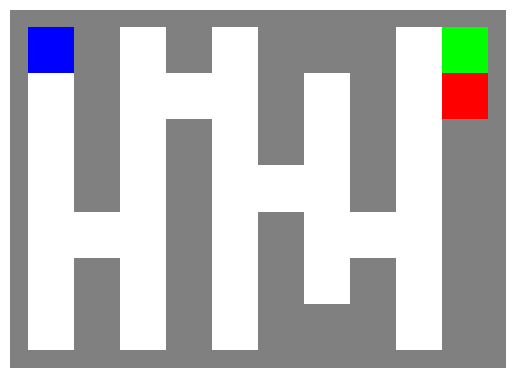

In [47]:
data = np.array([
    [1,0,1,0,1,0,0,0,1,3],
    [1,0,1,1,1,0,1,0,1,4],
    [1,0,1,0,1,0,1,0,1,0],
    [1,0,1,0,1,1,1,0,1,0],
    [1,1,1,0,1,0,1,1,1,0],
    [1,0,1,0,1,0,1,0,1,0],
    [1,0,1,0,1,0,0,0,1,0]
])

des = showMaze(data, 0)
plt.axis('off')
plt.imshow(des)
plt.show()

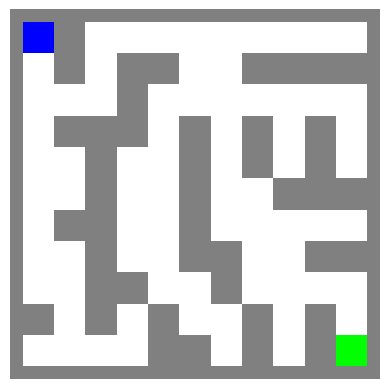

In [52]:
data = np.array([
    [1,0,1,1,1,1,1,1,1,1,1],
    [1,0,1,0,0,1,1,0,0,0,0],
    [1,1,1,0,1,1,1,1,1,1,1],
    [1,0,0,0,1,0,1,0,1,0,1],
    [1,1,0,1,1,0,1,0,1,0,1],
    [1,1,0,1,1,0,1,1,0,0,0],
    [1,0,0,1,1,0,1,1,1,1,1],
    [1,1,0,1,1,0,0,1,1,0,0],
    [1,1,0,0,1,1,0,1,1,1,1],
    [0,1,0,1,0,1,1,0,1,0,1],
    [1,1,1,1,0,0,1,0,1,0,3]
])

des = showMaze(data, 0)
plt.axis('off')
plt.imshow(des)
plt.show()

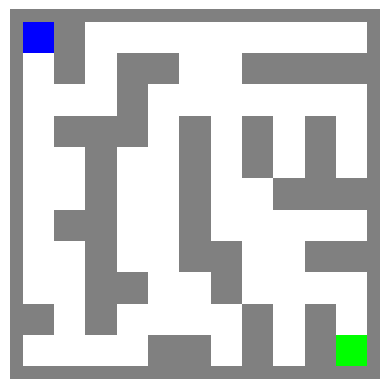

In [53]:
data = np.array([
    [1,0,1,1,1,1,1,1,1,1,1],
    [1,0,1,0,0,1,1,0,0,0,0],
    [1,1,1,0,1,1,1,1,1,1,1],
    [1,0,0,0,1,0,1,0,1,0,1],
    [1,1,0,1,1,0,1,0,1,0,1],
    [1,1,0,1,1,0,1,1,0,0,0],
    [1,0,0,1,1,0,1,1,1,1,1],
    [1,1,0,1,1,0,0,1,1,0,0],
    [1,1,0,0,1,1,0,1,1,1,1],
    [0,1,0,1,1,1,1,0,1,0,1],
    [1,1,1,1,0,0,1,0,1,0,3]
])

des = showMaze(data, 0)
plt.axis('off')
plt.imshow(des)
plt.show()